# Fold - Core Walkthrough


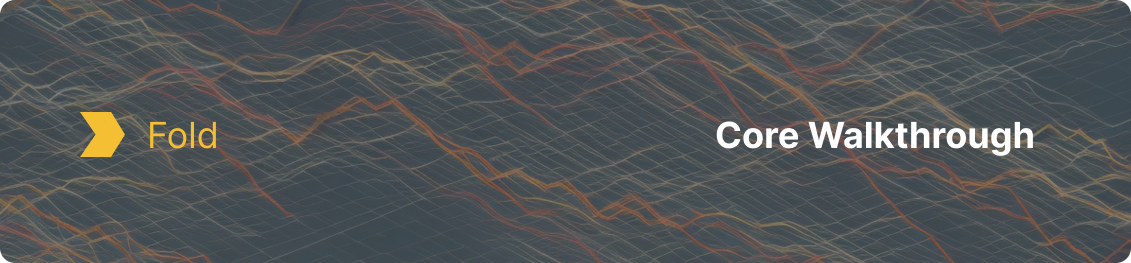


**Welcome 👋**

In this notebook we'll demonstrate `fold`'s powerful interface for creating, training, and cross-validating (or backtesting, if you prefer) simple and *composite* models/pipelines.

We will use the dataset from an [Energy residual load forcasting challenge](https://www.kaggle.com/competitions/energy-forecasting-data-challenge) hosted on Kaggle.

---

**By the end you will know how to:**
- Create a simple and ensemble model (composite model)
- Train multiple models / pipelines over time
- Analyze the model's simulated past performance

---

Let's start by installing:
- [`fold`](https://github.com/dream-faster/fold)
- [`fold-models`](https://github.com/dream-faster/fold-models): optional, this will be required later for third party models. Wraps eg. `XGBoost` or `StatsForecast` models to be used with `fold`.
- [`krisi`](https://github.com/dream-faster/krisi), optional. Dream Faster's Time-Series evaluation library to quickly get results.


### Installing libraries

In [ ]:
%%capture
pip install --quiet https://github.com/dream-faster/fold/archive/main.zip https://github.com/dream-faster/fold-models/archive/main.zip git+https://github.com/dream-faster/krisi.git@main matplotlib seaborn xgboost plotly prophet statsforecast statsmodels ray

# Data Loading and Exploration

Let's load in the data and do minimal exploration of the structure of the data. 

`fold` has a useful utility function that loads example data from our [`datasets`](https://github.com/dream-faster/datasets) GitHub repo. 

*   We are forecasting `residual_load`‡. 
*   We will shorten the dataset to `4000` rows so we have a speedier demonstration.


---

‡ *The difference between the `load` in the network and the `P` that the industrial complex is producing.*

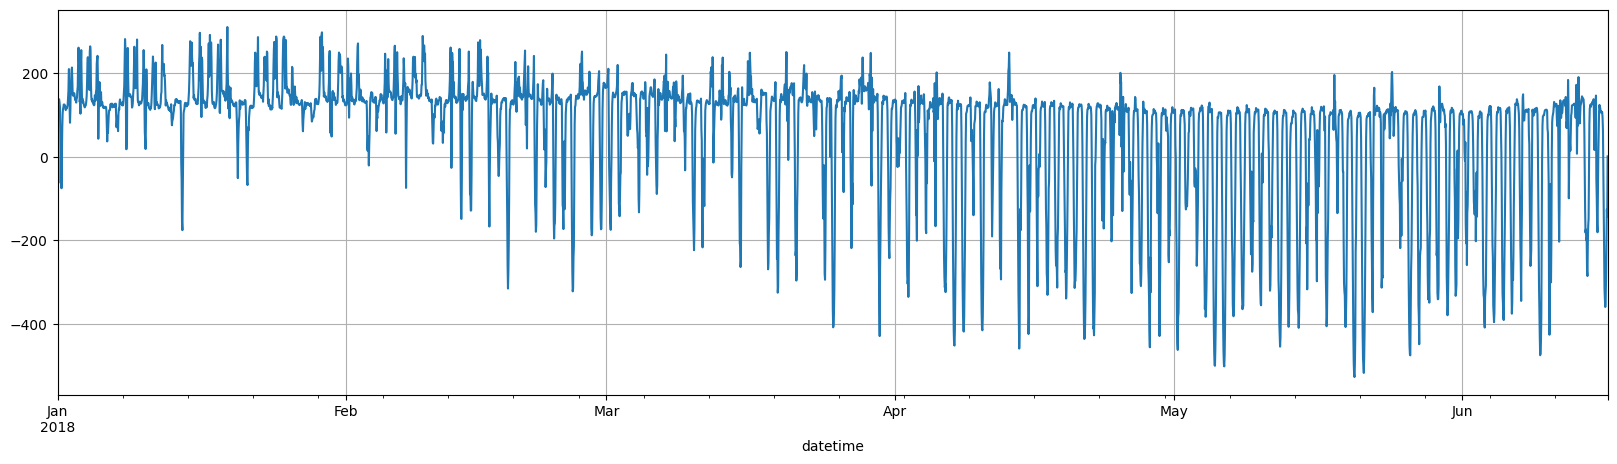

In [ ]:
from fold.utils.dataset import get_preprocessed_dataset
from statsmodels.graphics.tsaplots import plot_acf

X, y = get_preprocessed_dataset(
    "energy/industrial_pv_load",
    target_col="residual_load", 
    resample="H",
    deduplication_strategy="first",
    shorten=4000,
)
no_of_observation_per_day = 24
no_of_observation_per_week = no_of_observation_per_day * 7

y.plot(figsize = (20,5), grid=True);

The data format may be very familiar - it looks like the standard scikit-learn data.

`X` represents exogenous variables in `fold`, where a single row corresponds to a single target value. That means we currently only support univariate time-series (with exogenous variables), but soon we're extending that.

It's important that the data should be sorted and its integrity (no missing values, no duplicate indicies) should be checked before passing data to `fold`.

In [ ]:
X.head()

,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load
datetime,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,8.44,5.54,120.0,120.0
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,7.56,5.43,115.5,115.5
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,7.04,5.33,120.5,120.5
2018-01-01 03:00:00,0.0,0.0,0.0,0.0,6.48,5.67,123.5,123.5
2018-01-01 04:00:00,0.0,0.0,0.0,0.0,5.95,5.79,136.5,136.5


(We'll ignore the exogenous variables until a bit later)

In [ ]:
y.head()

datetime
2018-01-01 00:00:00    115.5
2018-01-01 01:00:00    120.5
2018-01-01 02:00:00    123.5
2018-01-01 03:00:00    136.5
2018-01-01 04:00:00    138.0
Freq: H, Name: residual_load, dtype: float64

You can see that `y` (our target) contains the next value of `X`'s "residual_load" column. 

# Time Series Cross Validation with a univariate forecaster
---

### 1. Model Building

`fold` has three core type of building blocks which you can build arbitrary sophisticated pipelines from:
- **Transformations** (classes that change, augment the data. eg: `AddHolidayFeatures` adds a column feature of holidays/weekends to your exogenous variables)
- **Models** (eg.: Sklearn, Baseline Models, third-party adapters from [`fold-models`](https://github.com/dream-faster/fold-models), like Statsmodels)
- **Composites** (eg.: `Ensemble` - takes the mean of the output of arbitrary number of 'parallel' models or pipelines)

Let's use Facebook's popular [`Prophet`](https://facebook.github.io/prophet/) library, and create in instance.

If [`fold-models`](https://github.com/dream-faster/fold-models) is installed, `fold` can take this instance without any additional wrapper class.

In [ ]:
from prophet import Prophet
prophet = Prophet()

### 2. Creating a Splitter

A splitter allows us to do Time Series Cross-Validation with various strategies.

`fold` supports three types of `Splitters`:
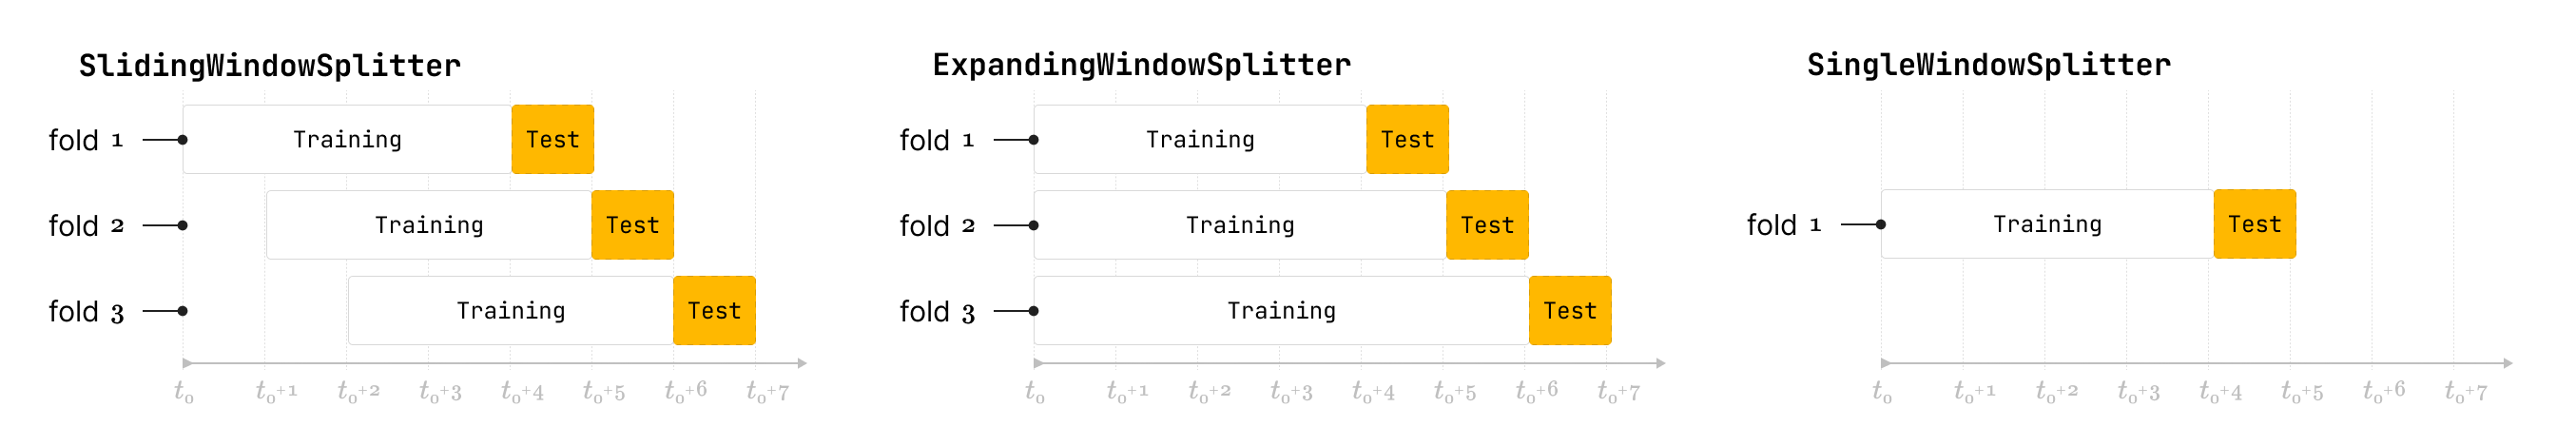

In [ ]:
from fold.splitters import ExpandingWindowSplitter

splitter = ExpandingWindowSplitter(
    initial_train_window=no_of_observation_per_week * 6,
    step=no_of_observation_per_week
)

Here, `initial_train_window` defines the first window size, `step` is the size of the window between folds.

We're gonna be using the first 6 weeks as our initial window, and re-train (or update, in another training mode) it every week after. We'll have 18 models, each predicting the next week's target variable.

You can also use percentages to define both, for example, `0.1` would be equivalent to `10%` of the availabel data.

### 3. Training a (univariate) Model

We could use [ray](https://www.ray.io/) to parallelize the training of multiple folds, halving the time it takes for every CPU core we have available (or deploying it to a cluster, if needed).

We pass in `None` as `X`, to indicate that we want to train a univariate model, without any exogenous variables.

In [ ]:
from fold import train_evaluate, Backend
import ray
ray.init(ignore_reinit_error=True)

scorecard, predictions, trained_pipeline = train_evaluate(prophet, None, y, splitter, backend=Backend.ray, krisi_args={"model_name":"prophet"})

(process_pipeline_window pid=820) 18:35:41 - cmdstanpy - INFO - Chain [1] start processing
(process_pipeline_window pid=821) 18:35:41 - cmdstanpy - INFO - Chain [1] start processing
(process_pipeline_window pid=820) 18:35:41 - cmdstanpy - INFO - Chain [1] done processing
(process_pipeline_window pid=821) 18:35:41 - cmdstanpy - INFO - Chain [1] done processing
(process_pipeline_window pid=821) 18:35:42 - cmdstanpy - INFO - Chain [1] start processing
(process_pipeline_window pid=820) 18:35:42 - cmdstanpy - INFO - Chain [1] start processing
(process_pipeline_window pid=820) 18:35:42 - cmdstanpy - INFO - Chain [1] done processing
(process_pipeline_window pid=821) 18:35:42 - cmdstanpy - INFO - Chain [1] done processing
(process_pipeline_window pid=821) 18:35:43 - cmdstanpy - INFO - Chain [1] start processing
(process_pipeline_window pid=820) 18:35:43 - cmdstanpy - INFO - Chain [1] start processing
(process_pipeline_window pid=821) 18:35:43 - cmdstanpy - INFO - Chain [1] done processing
(pro

  0%|          | 0/18 [00:00<?, ?it/s]

### 4. Evaluating the results

In [ ]:
scorecard.print('minimal')

Mean Absolute Error - 95.076         
          Mean Absolute Percentage Error - 7.9555e+13     
Symmetric Mean Absolute Percentage Error - 0.5092         
                      Mean Squared Error - 1.4779e+04     
                 Root Mean Squared Error - 121.57         
                               R-squared - 0.42684        
                   Mean of the Residuals - 6.3616         
     Standard Deviation of the Residuals - 121.42

In [ ]:
from krisi.report import plot_y_predictions
plot_y_predictions(y[predictions.index], predictions, mode="overlap", y_name="residual_load")

Finally, let's save the scorecard into a list, so we can compare the results later.

In [ ]:
results = [(scorecard, predictions)]

# Using an Ensemble (Composite) model
---

Here we will build an `Ensemble` model that leverages the output of multiple models. 

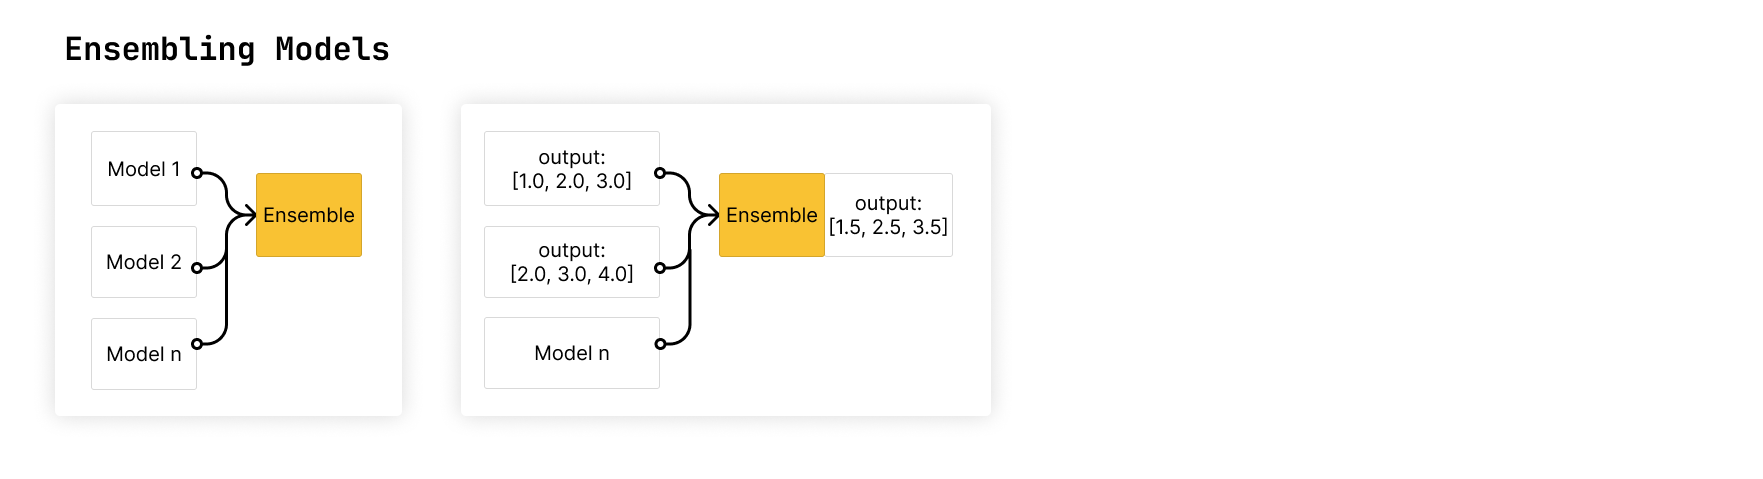

### 1. Model Building with `fold-models`

We are going to define three different pipelines, each leveraging a different model and different features.



We can leverage the most popular modelling libraries, like StatsForecast, Sktime, XGBoost, etc. (the list can be found [here](https://github.com/dream-faster/fold-models)).

Let's train a [MSTL](https://arxiv.org/abs/2107.13462) model that's implemented in [StatsForecast](https://nixtla.github.io/statsforecast/models.html), that can capture multiple seasonalities, with the `WrapStatsForecast` class from `fold-models`. This is not strictly necessary, though, as the automatic wrapping also works for StatsForecast instaces as well.

In [ ]:
from statsforecast.models import MSTL
from fold_models import WrapStatsForecast, WrapStatsModels

mstl = WrapStatsForecast.from_model(MSTL([24, 168]))

### 2. Ensembling with `fold`

Finally, let's `ensemble` the two pipelines.

In [ ]:
from fold.composites import Ensemble

univariate_ensemble = Ensemble([prophet, mstl])

### 3. Training all pipelines seperately and within an `ensemble`

We'll use the same `ExpandingWindowSplitter` we have defined above, to make performance comparable.

In [ ]:
from fold import train_evaluate

for name, pipeline in [
    ("mstl", mstl),
    ("univariate_ensemble",univariate_ensemble)
]:
    scorecard, predictions, pipeline_trained = train_evaluate(pipeline, None, y, splitter, krisi_args={"model_name":name})
    results.append((scorecard, predictions))

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w0qnddh/oty3tf2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w0qnddh/li76noka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59697', 'data', 'file=/tmp/tmp2w0qnddh/oty3tf2t.json', 'init=/tmp/tmp2w0qnddh/li76noka.json', 'output', 'file=/tmp/tmp2w0qnddh/prophet_modelmma8c3tm/prophet_model-20230411183611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w0qnddh/qx504ub0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w0qnddh/xv6jq2nr.json
DEBUG:cmdstanpy:idx 0
DEBU

  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
from krisi import compare

compare([scorecard for scorecard, predictions in results])

                    model_name    rmse            
                       prophet    121.57          
                          mstl    118.7           
           univariate_ensemble    105.96          


We see that our Ensemble model has beaten all individual models' performance - which is very usual in the time series context.

# Using a single-step ahead forecaster (a baseline)

So far we've used models that were costly to update (or re-train) every day, therefore we were limited to training once for every week, then predicting the next week's target.

What if we could use a lightweight, "online" model, that can be updated on every timestamp?

And.. what if we just repeat the last value?

That'd be the `Naive` model you can load from `fold_models`.

In [ ]:
from fold import train_evaluate
from fold_models import Naive

scorecard, predictions, trained_pipeline = train_evaluate(Naive(), None, y, splitter, krisi_args={"model_name":"naive"})
results.append((scorecard, predictions))
scorecard.print("minimal")

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Mean Absolute Error - 39.111         
          Mean Absolute Percentage Error - 2.1224e+14     
Symmetric Mean Absolute Percentage Error - 0.2038         
                      Mean Squared Error - 4012.9         
                 Root Mean Squared Error - 63.348         
                               R-squared - 0.84437        
                   Mean of the Residuals - -0.043877      
     Standard Deviation of the Residuals - 63.358

**We call this [Continous Validation](https://dream-faster.github.io/fold/concepts/continuous-validation/).**

It looks like having access to last value really makes a difference: the baseline model beats all long-term forecasting models by a large margin.

**It's extremely important to define our forecasting task well**:
1. We need to think about what time horizon can and should forecast
2. And how frequently can we update our models.

Long-horizon (in this case, a week ahead) forecasts can be very unreliable, on the other hand, frequent, short-term forecasts are where Machine Learning shines (as we'll see in the next section).

# Using exogenous variables with Tabular Models
---

So far we have been training univariate models, and ignored all the additional, exogenous variables that come with our data.

Let's try whether using this data boost our model's performance!


## Building Models separately


We'll be using scikit-learn's `HistGradientBoostingRegressor`, their competing implementation of Gradient Boosted Trees. You don't need to wrap `scikit-learn` models or transformations when using it in `fold`, just pass it in directly to any pipeline.

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

tree_model = HistGradientBoostingRegressor(max_depth=10)




Let's add both holiday and date-time features to our previous ensemble pipeline.

The data was gathered in the Region of Hessen, Germany -- so we pass in `DE` (we can pass in multiple regions). This transformation adds another column for holidays to our `exogenous` (`X`) features.

We're also adding the current hour, and day of week as integers to our exogenous features. This is one of the ways for our tabular model to capture seasonality.


In [ ]:
from fold.transformations import AddHolidayFeatures, AddDateTimeFeatures

datetime = AddDateTimeFeatures(['hour', 'day_of_week', 'day_of_year'])
holidays = AddHolidayFeatures(['DE'])


Let's add a couple of lagged, exogenous values for our model. `AddLagsX` receives a tuple of column name and integer or list of lags, for each of which it will create a column in `X`.

We can easily create transformations of existing features on a rolling window basis with `AddWindowFeatures` as well, in this case, the last day's average value for all of our exogenous features.

We can "tie in" two separate pipelines with `Concat`, which concatenates all columns from all sources.

In [ ]:
from fold.transformations import AddWindowFeatures, AddLagsX
from fold.composites import Concat

tree = [
    Concat([
        AddLagsX(("all",range(1,3))),
        AddWindowFeatures([("all", 24, "mean")]),
    ]),
    datetime,
    holidays,
    tree_model
]

Let's see how this performs!

We can also use fold's `train`, `backtest` to decouple these functionalities.

In [ ]:
from fold import train, backtest
from krisi import score

trained_pipeline = train(tree, X, y, splitter)
predictions = backtest(trained_pipeline, X, y, splitter)
scorecard = score(y[predictions.index], predictions.squeeze(), model_name="tabular_tree")

results.append((scorecard, predictions))
scorecard.print("minimal")

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Mean Absolute Error - 29.653         
          Mean Absolute Percentage Error - 2.1232e+14     
Symmetric Mean Absolute Percentage Error - 0.15915        
                      Mean Squared Error - 2637.6         
                 Root Mean Squared Error - 51.357         
                               R-squared - 0.89771        
                   Mean of the Residuals - -1.7471        
     Standard Deviation of the Residuals - 51.336

## Creating an Ensemble of Tabular models

First let's creat two more models:
* an Sklearn LinearRegressor
* and an XGBoostRegressor instance

We are also going to use the HistGradientBoostingRegressor pipeline that we defined prior.


In [ ]:
from sklearn.linear_model import LinearRegression

lregression = [
    AddLagsX(('all',range(1,3))),
    datetime,
    LinearRegression()
]

In [ ]:
from xgboost import XGBRegressor
from fold_models.xgboost import WrapXGB

xgboost = [
    AddLagsX(('all',range(1,3))),
    datetime,
    WrapXGB.from_model(XGBRegressor())
]

In [ ]:
tabular_ensemble = Ensemble([lregression, xgboost, tree])

In [ ]:
scorecard, predictions, pipeline_trained = train_evaluate(tabular_ensemble, X, y, splitter, krisi_args={"model_name":"tabular_ensemble"})
results.append((scorecard, predictions))

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

# Comparing & Vizualising the results
---

In [ ]:
compare([scorecard for scorecard, _ in results])

                    model_name    rmse            
                       prophet    121.57          
                          mstl    118.7           
           univariate_ensemble    105.96          
                         naive    63.348          
                  tabular_tree    51.357          
              tabular_ensemble    48.229          


In this simplistic, unfair comparison, it looks like the tabular models (and the Naive baseline) that have access to the previous value (and the exogenous variables) outperform the univariate models that are only re-trained every week. 

We can't really draw general conclusions from this work, though. 

Unlike NLP and Computer vision, Time Series data is very heterogeneous, and a Machine Learning approach that works well for one series may be an inferior choice for your specific usecase.

---

But now we have an easy way to compare the different pipelines, with unprecedented speed, by using a unified interface, with [fold](https://github.com/dream-faster/fold). 




In [ ]:
all_predictions =[predictions.squeeze().rename(scorecard.metadata.model_name) for scorecard, predictions in results]

plot_y_predictions(y[predictions.index], all_predictions, y_name="residual_load", mode='seperate')

Want to know more?
Visit [fold's Examples page](https://dream-faster.github.io/fold/), and access all the necessary snippets you need for you to build a Time Series ML pipeline!